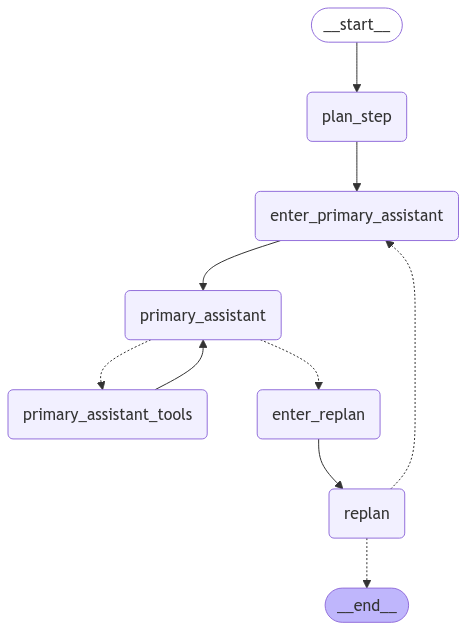

In [4]:
from typing import Annotated, Literal, Optional, List, Tuple, Union, Callable
from langchain_openai import ChatOpenAI
from typing_extensions import TypedDict
from pydantic import BaseModel
from langgraph.graph.message import AnyMessage, add_messages
from langchain_anthropic import ChatAnthropic
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import Runnable, RunnableConfig
from datetime import datetime
from langchain_core.tools import tool
from pydantic import BaseModel, Field
import operator
import pandas as pd
from scipy import stats
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph
from langgraph.prebuilt import tools_condition
from langchain_core.messages import ToolMessage
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import ToolMessage
from langchain_core.runnables import RunnableLambda
from langgraph.prebuilt import ToolNode
# tools:
# @tool
# def calculate_dataframe_column_stats(dataframe: pd.DataFrame, column: str) -> dict:
#     """
#     Calculate the maximum, minimum, mean, median, and mode of a column in the dataframe.

#     Args:
#         dataframe (pd.DataFrame): The dataframe containing the data.
#         column (str): The column name to calculate the statistics for.

#     Returns:
#         dict: A dictionary containing the maximum, minimum, mean, median, and mode of the column.
#     """
#     # Ensure the column exists in the dataframe
#     if column not in dataframe.columns:
#         raise ValueError(f"Column '{column}' not found in the dataframe")

#     # Calculate statistics for the specified column
#     max_value = dataframe[column].max()
#     min_value = dataframe[column].min()
#     mean_value = dataframe[column].mean()
#     median_value = dataframe[column].median()
#     mode_value = stats.mode(dataframe[column])[0][0]  # Mode returns an array, we take the first element

#     # Create the result dictionary
#     result = {
#         "max": max_value,
#         "min": min_value,
#         "mean": mean_value,
#         "median": median_value,
#         "mode": mode_value
#     }

#     return result





def update_dialog_stack(left: list[str], right: Optional[str]) -> list[str]:
    """Push or pop the state."""
    if right is None:
        return left
    if right == "pop":
        return left[:-1]
    return left + [right]

class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
    dialog_state: Annotated[
        list[
            Literal[
                "assistant",
                "update_flight",
                "book_car_rental",
                "book_hotel",
                "book_excursion",
            ]
        ],
        update_dialog_stack,
    ]

class Assistant:
    def __init__(self, runnable: Runnable):
        self.runnable = runnable

    def __call__(self, state: State, config: RunnableConfig):
        while True:
            result = self.runnable.invoke(state)

            if not result.tool_calls and (
                not result.content
                or isinstance(result.content, list)
                and not result.content[0].get("text")
            ):
                messages = state["messages"] + [("user", "Respond with a real output.")]
                state = {**state, "messages": messages}
            else:
                break
        return {"messages": result}


class CompleteOrEscalate(BaseModel):
    """A tool to mark the current task as completed and/or to escalate control of the dialog to the main assistant,
    who can re-route the dialog based on the user's needs."""

    cancel: bool = True
    reason: str

    class Config:
        json_schema_extra = {
            "example": {
                "cancel": True,
                "reason": "User changed their mind about the current task.",
            },
            "example 2": {
                "cancel": True,
                "reason": "I have fully completed the task.",
            },
            "example 3": {
                "cancel": False,
                "reason": "I need to search the user's emails or calendar for more information.",
            },
        }

# utils

def handle_tool_error(state) -> dict:
    error = state.get("error")
    tool_calls = state["messages"][-1].tool_calls
    return {
        "messages": [
            ToolMessage(
                content=f"Error: {repr(error)}\n please fix your mistakes.",
                tool_call_id=tc["id"],
            )
            for tc in tool_calls
        ]
    }


def create_tool_node_with_fallback(tools: list) -> dict:
    return ToolNode(tools).with_fallbacks(
        [RunnableLambda(handle_tool_error)], exception_key="error"
    )


def _print_event(event: dict, _printed: set, max_length=1500):
    current_state = event.get("dialog_state")
    if current_state:
        print("Currently in: ", current_state[-1])
    message = event.get("messages")
    if message:
        if isinstance(message, list):
            message = message[-1]
        if message.id not in _printed:
            msg_repr = message.pretty_repr(html=True)
            if len(msg_repr) > max_length:
                msg_repr = msg_repr[:max_length] + " ... (truncated)"
            print(msg_repr)
            _printed.add(message.id)
def create_entry_node(assistant_name: str, new_dialog_state: str) -> Callable:
    def entry_node(state: State) -> dict:
        tool_call_id = state["messages"][-1].tool_calls[0]["id"]
        return {
            "messages": [
                ToolMessage(
                    content=f"The assistant is now the {assistant_name}. Reflect on the above conversation between the host assistant and the user."
                    f" The user's intent is unsatisfied. Use the provided tools to assist the user. Remember, you are {assistant_name},"
                    " and the booking, update, other other action is not complete until after you have successfully invoked the appropriate tool."
                    " If the user changes their mind or needs help for other tasks, call the CompleteOrEscalate function to let the primary host assistant take control."
                    " Do not mention who you are - just act as the proxy for the assistant.",
                    tool_call_id=tool_call_id,
                )
            ],
            "dialog_state": new_dialog_state,
        }

    return entry_node

# 计划步骤
class PlanExecute(TypedDict):
    input: str
    plan: List[str]
    past_steps: Annotated[List[Tuple], operator.add]
    response: str

class Plan(BaseModel):
    """Plan to follow in future"""

    steps: List[str] = Field(
        description="different steps to follow, should be in sorted order"
    )
planner_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """For the given objective, come up with a simple step by step plan. \
This plan should involve individual tasks, that if executed correctly will yield the correct answer. Do not add any superfluous steps. \
The result of the final step should be the final answer. Make sure that each step has all the information needed - do not skip steps.""",
        ),
        ("placeholder", "{messages}"),
    ]
)
planner = planner_prompt | ChatOpenAI(
    model="gpt-4o", temperature=0
).with_structured_output(Plan)
async def plan_step(state: PlanExecute):
    plan = await planner.ainvoke({"messages": [("user", state["input"])]})
    return {"plan": plan.steps}



# 重计划步骤
class Response(BaseModel):
    """Response to user."""

    response: str


class Act(BaseModel):
    """Action to perform."""

    action: Union[Response, Plan] = Field(
        description="Action to perform. If you want to respond to user, use Response. "
        "If you need to further use tools to get the answer, use Plan."
    )


replanner_prompt = ChatPromptTemplate.from_template(
    """For the given objective, come up with a simple step by step plan. \
This plan should involve individual tasks, that if executed correctly will yield the correct answer. Do not add any superfluous steps. \
The result of the final step should be the final answer. Make sure that each step has all the information needed - do not skip steps.

Your objective was this:
{input}

Your original plan was this:
{plan}

You have currently done the follow steps:
{past_steps}

Update your plan accordingly. If no more steps are needed and you can return to the user, then respond with that. Otherwise, fill out the plan. Only add steps to the plan that still NEED to be done. Do not return previously done steps as part of the plan."""
)
replanner = replanner_prompt | ChatOpenAI(
    model="gpt-4o", temperature=0
).with_structured_output(Act)
async def replan_step(state: PlanExecute):
    output = await replanner.ainvoke(state)
    if isinstance(output.action, Response):
        return {"response": output.action.response}
    else:
        return {"plan": output.action.steps}
      
      
builder = StateGraph(State)      


# 主agent
primary_assistant_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a specialized assistant for data analyst. "
            "\nCurrent time: {time}."
            "\n\nIf the user needs help, and none of your tools are appropriate for it, then"
            ' "CompleteOrEscalate" the dialog to the host assistant. Do not waste the user\'s time. Do not make up invalid tools or functions.',
        ),
        ("placeholder", "{messages}"),
    ]
).partial(time=datetime.now)

llm = ChatOpenAI(model="gpt-4o", temperature=0)

primary_assistant_tools = [
    TavilySearchResults(max_results=2),
]
class ToReplan(BaseModel):
    """Transfer the work to the re planning assistant. """

    request: str = Field(
        description="After completing the task analysis, determine whether it is necessary to re plan."
    )
class ToPrimaryAssistant(BaseModel):
    """Transfer the work to the primary assistant. """

    request: str = Field(
        description="Transfer the work to the primary assistant."
    )
assistant_runnable = primary_assistant_prompt | llm.bind_tools(
    primary_assistant_tools
    + [ToReplan]
)

# 构建图
builder = StateGraph(State)
builder.add_node("plan_step",plan_step)

builder.add_node(
    "enter_primary_assistant",
    create_entry_node("primary assistant", "primary assistant"),
)
builder.add_node("primary_assistant", Assistant(assistant_runnable))
builder.add_node("primary_assistant_tools", create_tool_node_with_fallback(primary_assistant_tools))
builder.add_node(
    "enter_replan",
    create_entry_node("enter replan", "enter_replan"),
)
builder.add_node("replan", replan_step)


def route_primary_assistant(
    state: State,
):
    route = tools_condition(state)
    if route == END:
        return END
    tool_calls = state["messages"][-1].tool_calls
    if tool_calls:
        if tool_calls[0]["name"] == ToReplan.__name__:
            return "enter_replan"
    raise ValueError("Invalid route")
def route_to_workflow(
    state: State,
) -> Literal[
    "primary_assistant",
]:
    """If we are in a delegated state, route directly to the appropriate assistant."""
    dialog_state = state.get("dialog_state")
    if not dialog_state:
        return "primary_assistant"
    return dialog_state[-1]

def route_replan_assistant(
    state: State,
):
    route = tools_condition(state)
    if route == END:
        return END
    tool_calls = state["messages"][-1].tool_calls
    if tool_calls:
        if tool_calls[0]["name"] == ToPrimaryAssistant.__name__:
            return "enter_primary_assistant"
    raise ValueError("Invalid route")
builder.add_edge(START, "plan_step")
builder.add_edge("plan_step", "enter_primary_assistant")
builder.add_edge("enter_primary_assistant", "primary_assistant")
builder.add_conditional_edges(
    "primary_assistant",
    route_primary_assistant,
    [
        "enter_replan",
        "primary_assistant_tools"
    ],
) 
builder.add_edge("primary_assistant_tools", "primary_assistant")

builder.add_edge("enter_replan", "replan")

builder.add_conditional_edges(
    "replan",
    route_replan_assistant,
    [
        "enter_primary_assistant",
        END,
    ],
) 

memory = MemorySaver()
part_4_graph = builder.compile(
    checkpointer=memory,
)

from IPython.display import Image, display

display(Image(part_4_graph.get_graph(xray=True).draw_mermaid_png()))
